In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import inv_boxcox
from scipy.stats import anderson


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

from utils import *

In [2]:
df1 = pd.read_csv("../ExploratoryDataAnalysis/cleaned_cardata.csv") 

# The following steps are performed in the linear regression code. For description check that out.

CatCols = df1.select_dtypes(include=['object', 'category']).columns.tolist()
df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)

x = df1.drop("Selling_Price", axis=1)
y = df1["Selling_Price"]

X_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.25, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)




StandardScaler()

**To Get to know your data and `determine feature variables and the target variable`** please check DataPreparation and ExploratoryDataAnalysis. There a brief description of how to learn about your data is provided. Also, linear regression is performed in Regression_linear. This code is the following of Linear regression step.

##### **Step 1: Box-Cox Transformation**
To meet the assumptions of regression, we apply the Box-Cox transformation to the entire dataset. This transformation adjusts the shape of our data, bringing it closer to a normal distribution.

To avoid data leakage, the lambda value for each feature is determined using the training dataset, and then this transformation is applied to both the training and test data.


In [3]:
fitted_lambda = pd.Series(np.zeros(len(df1.columns), dtype=np.float64), index=df1.columns)

y_train, fitted_lambda['Selling_Price'] = stats.boxcox(y_train + 1)

for col in X_train.columns:
    X_train[col], fitted_lambda[col] = stats.boxcox(X_train[col] + 1)

fitted_lambda


Age                       -0.545231
Selling_Price             -0.024628
Present_Price              0.084631
Kms_Driven                 0.355793
Owner                    -29.378517
Fuel_Type_Diesel          -7.675964
Fuel_Type_Petrol           7.268215
Seller_Type_Individual    -2.604515
Transmission_Manual       15.384911
dtype: float64

To transform the test data using the lambda values obtained from the training set, we apply the previously calculated lambda for each feature. This ensures that the test data undergoes the same transformation as the training data, maintaining consistency in data preprocessing. By applying the Box-Cox transformation with these lambda values, we prepare the test set for accurate model evaluation without introducing data leakage.

In [4]:
y_test = stats.boxcox(y_test + 1, fitted_lambda['Selling_Price'])

for col in x_test.columns:
    x_test[col] = stats.boxcox(x_test[col] + 1, fitted_lambda[col])


In [5]:
# Convert y_train and y_test to DataFrames with 'Selling_Price' as the column name
y_train = pd.DataFrame(y_train, index=X_train.index, columns=['Selling_Price'])
y_test = pd.DataFrame(y_test, index=x_test.index, columns=['Selling_Price'])

# Concatenate the training and test sets for X and y
X_boxcox = pd.concat([X_train, x_test])
y_boxcox = pd.concat([y_train, y_test])

# Combine X and y into a single DataFrame and sort by index
df_boxcox = pd.concat([X_boxcox, y_boxcox], axis=1)
df_boxcox.sort_index(inplace=True)

# Remove the 'Fuel_Type_Petrol' column
del df_boxcox['Fuel_Type_Petrol']



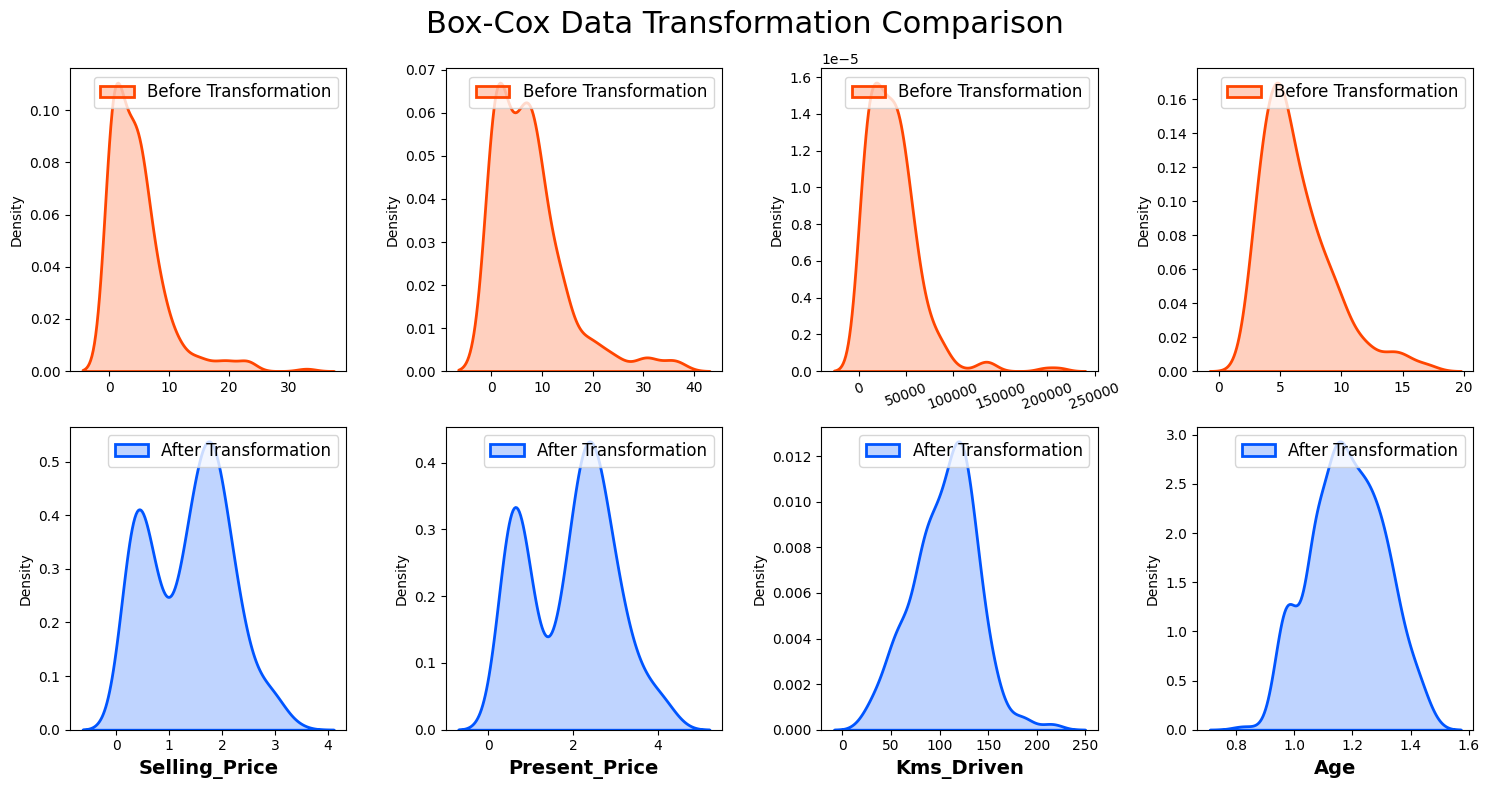

In [6]:
# Create a 2x4 grid of subplots with specified figure size and resolution
fig, ax = plt.subplots(2, 4, figsize=(15, 8), dpi=100)
features = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Age']

# Loop through the selected features to plot KDEs
for idx, feature in enumerate(features):
    # Plot KDE for original data
    sns.kdeplot(df1[feature], label="Before Transformation", fill=True, color='#ff4500', linewidth=2, ax=ax[0, idx])
    # Plot KDE for Box-Cox transformed data
    sns.kdeplot(df_boxcox[feature], label="After Transformation", fill=True, color='#0055ff', linewidth=2, ax=ax[1, idx])

    # Customize x-axis labels
    ax[0, idx].set_xlabel('', fontsize=14)
    ax[1, idx].set_xlabel(feature, fontsize=14, fontweight='bold')

    # Add legends to the plots
    ax[0, idx].legend(loc="upper right", fontsize=12)
    ax[1, idx].legend(loc="upper right", fontsize=12)

# Rotate x-axis labels for the third plot in the first row
ax[0, 2].tick_params(axis='x', labelrotation=20)

# Add a main title for the figure
plt.suptitle('Box-Cox Data Transformation Comparison', fontsize=22)

# Adjust spacing and show the plots
plt.tight_layout()
plt.show()


Based on the results of the Box-Cox transformation, we will select the features for the x and y axes. The transformation has clarified which variables are more normally distributed, allowing for more informed and effective feature selection for modeling. This approach ensures that the chosen features for x and y are well-suited for regression analysis and improve the overall performance of the model.

In [7]:
X = df_boxcox.drop('Selling_Price', axis=1)
y = df_boxcox['Selling_Price']

##### **Step 2: Polynomial Regression: 2nd order**

To enhance the feature set, polynomial features with a degree of 2 are generated from the original dataset `X` using `PolynomialFeatures`. This transformation includes interaction terms between features but excludes the bias term. The transformed features are then converted into a DataFrame with column names corresponding to the new polynomial terms. This process allows for capturing nonlinear relationships and interactions between features, which can improve the model's ability to fit complex patterns in the data. The first five rows of the transformed DataFrame are displayed to inspect the newly created features.

In [8]:
# Create polynomial features with degree 2 and without bias term
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# Transform the feature set X to include polynomial features
X_poly = poly_features.fit_transform(X)

# Convert the transformed features into a DataFrame with appropriate column names
X_poly = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X.columns))

# Display the first 5 rows of the transformed DataFrame
X_poly.head(5)


,Age,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual,Age^2,Age Present_Price,Age Kms_Driven,...,Owner^2,Owner Fuel_Type_Diesel,Owner Seller_Type_Individual,Owner Transmission_Manual,Fuel_Type_Diesel^2,Fuel_Type_Diesel Seller_Type_Individual,Fuel_Type_Diesel Transmission_Manual,Seller_Type_Individual^2,Seller_Type_Individual Transmission_Manual,Transmission_Manual^2
0,1.199272,2.044330,103.226063,0.0,0.00000,0.0,2781.087536,1.438254,2.451707,123.796139,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,7.734448e+06
1,1.243848,2.606298,122.319372,0.0,0.12964,0.0,2781.087536,1.547157,3.241838,152.146660,...,0.0,0.0,0.0,0.0,0.016806,0.0,360.539503,0.0,0.0,7.734448e+06
2,0.972779,2.641723,62.451367,0.0,0.00000,0.0,2781.087536,0.946298,2.569812,60.751356,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,7.734448e+06
3,1.311462,1.758112,56.204048,0.0,0.00000,0.0,2781.087536,1.719933,2.305697,73.709485,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,7.734448e+06
4,1.199272,2.254117,121.747576,0.0,0.12964,0.0,2781.087536,1.438254,2.703299,146.008474,...,0.0,0.0,0.0,0.0,0.016806,0.0,360.539503,0.0,0.0,7.734448e+06


In [9]:
# Retrieve the names of the polynomial features and count their total number
poly_feature_names = poly_features.get_feature_names_out(X.columns)
num_poly_features = len(poly_feature_names)


##### **Step 3: Split Dataset to Training & Test Sets**
This step divides the dataset into training and test sets, with 20% of the data reserved for testing. This separation allows us to train the model on one subset and evaluate its performance on an unseen subset.

In [10]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

##### **Step 4: Scale Data using Standard Scaler**
Scaling standardizes the features by removing the mean and scaling to unit variance, which helps improve the performance of many machine learning algorithms. The scaler is fit on the training data and then applied to both the training and test sets.

In [11]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=poly_feature_names)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=poly_feature_names)


##### **Step 5: Create Polynomial Regression Model using Linear Regression**
A linear regression model is created to fit the polynomial features. This model is trained using the scaled training data, allowing it to learn the relationships between the polynomial features and the target variable.

In [12]:

# Initialize the Linear Regression model
poly_model = LinearRegression()

# Train the model on the scaled training data
poly_model.fit(X_train_scaled, y_train)

LinearRegression()

##### **Step 6: Model Evaluation**
This step evaluates the performance of the polynomial regression model by making predictions on the test data. Metrics such as Mean Squared Error (MSE) and R^2 Score are calculated to assess how well the model fits the test data.

In [13]:
# Predict on the test data
y_pred = poly_model.predict(X_test_scaled)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the results
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 0.01
R^2 Score: 0.99


Now lets call the evaluation function:

In [14]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2_score = metrics.r2_score(y_test, y_pred)
    
    results = [mae, mse, rmse, r2_score]
    return pd.DataFrame(results, index=['MAE', 'MSE', 'RMSE', 'R2 Score'], columns=[model_name])

In [15]:

evaluate_model(poly_model, X_test_scaled, y_test, "polynomial Regression:")

,polynomial Regression:
MAE,0.081962
MSE,0.010355
RMSE,0.101758
R2 Score,0.985001


##### **Step 7: Cross-Validation and Model Evaluation**
This step involves evaluating the polynomial regression model using cross-validation. A pipeline is created to sequentially apply polynomial feature transformation, standard scaling, and linear regression. Using K-Fold cross-validation with 6 splits, the model's performance is assessed based on multiple metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R^2 Score. The results are summarized in a DataFrame showing both the mean and standard deviation of each metric, providing a comprehensive view of the model's performance.

In [16]:
# Create a pipeline that includes polynomial feature generation, scaling, and linear regression
pipeline = make_pipeline(
    PolynomialFeatures(degree=2), 
    StandardScaler(), 
    LinearRegression()
)

# Initialize KFold cross-validation
kf = KFold(n_splits=6, shuffle=True, random_state=0)

# Define scoring metrics
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']

# Perform cross-validation and collect results
results = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

# Calculate mean and standard deviation for each metric
mae_mean = -results['test_neg_mean_absolute_error'].mean()
mae_std = -results['test_neg_mean_absolute_error'].std()
mse_mean = -results['test_neg_mean_squared_error'].mean()
mse_std = -results['test_neg_mean_squared_error'].std()
rmse_mean = -results['test_neg_root_mean_squared_error'].mean()
rmse_std = -results['test_neg_root_mean_squared_error'].std()
r2_mean = results['test_r2'].mean()
r2_std = results['test_r2'].std()

# Create a DataFrame to display the results
metrics_summary = pd.DataFrame({
    'Mean': [mae_mean, mse_mean, rmse_mean, r2_mean], 
    'Std': [mae_std, mse_std, rmse_std, r2_std]
}, index=['MAE', 'MSE', 'RMSE', 'R2 Score'])

metrics_summary


,Mean,Std
MAE,0.090007,-0.024203
MSE,0.017814,-0.012140
RMSE,0.126194,-0.043467
R2 Score,0.968857,0.020875


##### **Step 8: Assumption Investigation:**
In regression analysis, several key assumptions must be validated to ensure the model's reliability and accuracy. Here are the typical assumptions and corresponding code to investigate them:

##### **Assumption 1: Linearity**

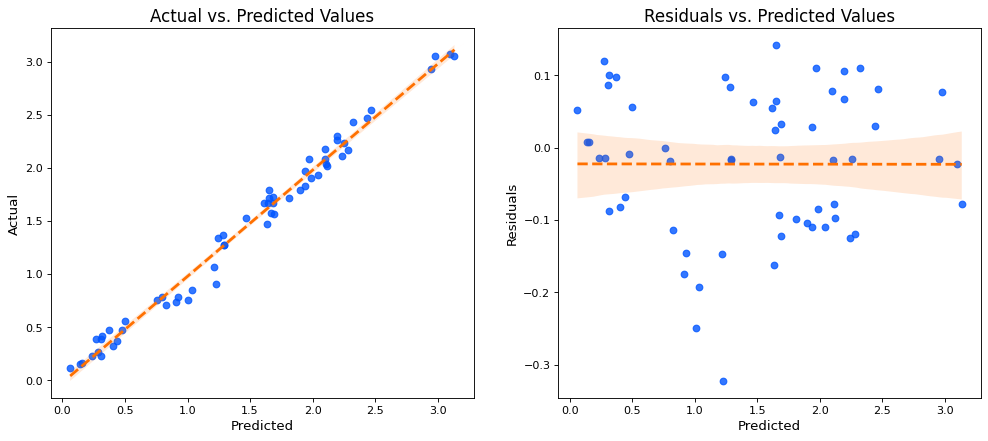

In [17]:

check_linearity_assumption(poly_model, X_test_scaled, y_test)

6.2. **Independence:**

The `autocorrelation_assumption` function assesses whether the residuals from a regression model exhibit autocorrelation. It calculates the Durbin-Watson statistic to test for serial correlation in the residuals. The function prints whether the residuals show signs of positive or negative autocorrelation or if the assumption of no autocorrelation is satisfied.

In [18]:

autocorrelation_assumption(poly_model, X_test_scaled, y_test)

Durbin-Watson Statistic: 2.539
Possible negative autocorrelation detected. Assumption not satisfied.


6.3. **Homoscedasticity:**


The horizontal line should be flat if homoscedasticity assumption is met.


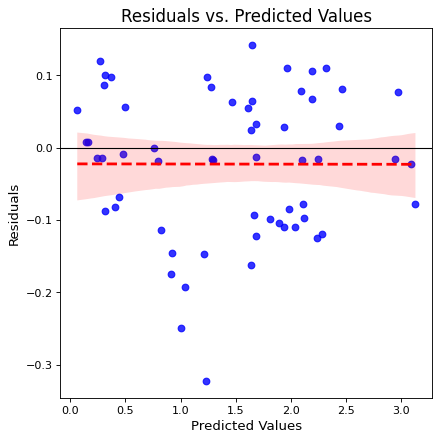

In [19]:
homoscedasticity_assumption(poly_model, X_test_scaled, y_test)